<a href="https://colab.research.google.com/github/totiela/ML/blob/main/credit_scoring_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# импорт библиотек

In [119]:
!pip install catboost

In [120]:
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [122]:
DATASET_PATH = "https://raw.githubusercontent.com/evgpat/stepik_from_idea_to_mvp/main/datasets/credit_scoring.csv"

# загрузка и обзор данных

In [123]:
df = pd.read_csv(DATASET_PATH)

# описание данных

**Целевая переменная**
- `SeriousDlqin2yrs`: клиент имел просрочку 90 и более дней

**Признаки**
- `RevolvingUtilizationOfUnsecuredLines`: общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt
like car loans divided by the sum of credit limits)
- `age`: возраст заемщика
- `NumberOfTime30-59DaysPastDueNotWorse`: сколько раз за последние 2 года наблюдалась просрочка 30-59 дней
- `DebtRatio`: ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход
- `MonthlyIncome`: ежемесячный доход
- `NumberOfOpenCreditLinesAndLoans`: количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт
- `NumberOfTimes90DaysLate`: сколько раз наблюдалась просрочка (90 и более дней)
- `RealEstateLoansOrLines`: закодированное количество кредиов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов
- `NumberOfTime60-89DaysPastDueNotWorse`: сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней
- `NumberOfDependents`: количество иждивенцев на попечении (супруги, дети и др)
- `GroupAge`: закодированная возрастная группа - чем больше код, тем больше возраст

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

In [125]:
df.sample(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
52778,0,0.058086,42.0,0,0.236680,7000.0,2,0,0,2.0,A,c
25067,0,0.033487,73.0,0,0.106737,8000.0,9,0,0,0.0,A,e
27252,0,0.970296,59.0,0,0.512273,4073.0,5,0,0,0.0,A,d
66693,0,0.923802,36.0,0,0.390336,6642.0,8,0,0,0.0,A,c
84760,0,0.000000,55.0,0,0.681773,3000.0,6,0,0,0.0,A,d
140349,1,0.007748,59.0,0,1566.000000,NaN,7,1,0,2.0,A,d
80104,0,0.043216,57.0,0,0.465586,4750.0,9,0,0,2.0,A,d
58287,0,1.000000,62.0,0,0.000000,864.0,0,1,0,0.0,A,d
27890,0,0.382817,66.0,0,1547.000000,NaN,6,0,0,0.0,A,e
120992,0,0.265895,NaN,1,0.421175,9000.0,10,0,0,1.0,A,e


In [126]:
df['SeriousDlqin2yrs'].value_counts() #распределение целевой переменной

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [127]:
df.isnull().sum() #смотрим количество пропусков

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                     14845
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

In [128]:
df.groupby('GroupAge')['age'].count() # находим единичное значение в слобце GroupAge(выброс)

GroupAge
a        1
b    17343
c    42458
d    47268
e    28085
Name: age, dtype: int64

In [129]:
df = df[df['GroupAge']!='a'] # удаляем выброс в столбце GroupAge

In [130]:
df[df['age'].isnull()] #смотрим какие пропуски по столбцу Age (всего 14845 строк)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
10,0,0.006146,NaN,0,3.000000,NaN,2,0,0,NaN,A,e
281,0,0.324305,NaN,1,5835.000000,NaN,8,0,0,0.0,B,e
359,0,0.004196,NaN,1,0.478190,8000.0,12,0,0,1.0,A,e
360,0,0.020212,NaN,0,0.302396,5300.0,13,0,0,0.0,A,e
401,0,0.000000,NaN,0,0.000000,NaN,2,0,0,1.0,A,e
...,...,...,...,...,...,...,...,...,...,...,...,...
149021,0,0.479919,NaN,0,3616.000000,NaN,12,0,0,NaN,A,e
149022,0,0.018460,NaN,0,813.000000,NaN,4,0,0,NaN,A,e
149023,0,0.015341,NaN,0,337.000000,NaN,4,0,0,NaN,A,e
149024,0,1.015566,NaN,0,302.000000,NaN,5,0,0,NaN,A,e


In [131]:
df[(df['GroupAge'] == 'e') & (df['age'].isnull())] # отмечаем что все пропуски относятся к категории 'e' столбца GroupAge

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
10,0,0.006146,NaN,0,3.000000,NaN,2,0,0,NaN,A,e
281,0,0.324305,NaN,1,5835.000000,NaN,8,0,0,0.0,B,e
359,0,0.004196,NaN,1,0.478190,8000.0,12,0,0,1.0,A,e
360,0,0.020212,NaN,0,0.302396,5300.0,13,0,0,0.0,A,e
401,0,0.000000,NaN,0,0.000000,NaN,2,0,0,1.0,A,e
...,...,...,...,...,...,...,...,...,...,...,...,...
149021,0,0.479919,NaN,0,3616.000000,NaN,12,0,0,NaN,A,e
149022,0,0.018460,NaN,0,813.000000,NaN,4,0,0,NaN,A,e
149023,0,0.015341,NaN,0,337.000000,NaN,4,0,0,NaN,A,e
149024,0,1.015566,NaN,0,302.000000,NaN,5,0,0,NaN,A,e


<Axes: xlabel='age', ylabel='Count'>

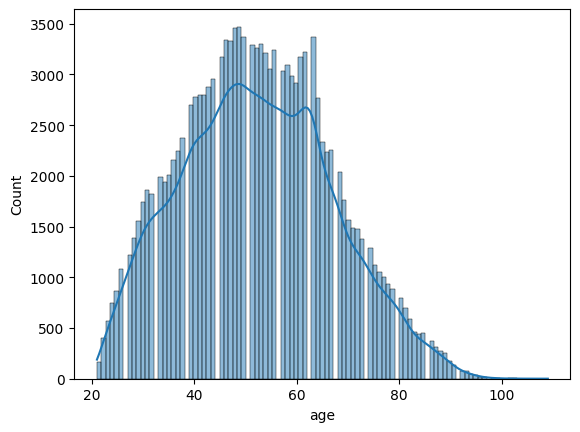

In [132]:
sns.histplot(df['age'], kde=True) #смотрим общее распределение возраста

<Axes: xlabel='age', ylabel='Count'>

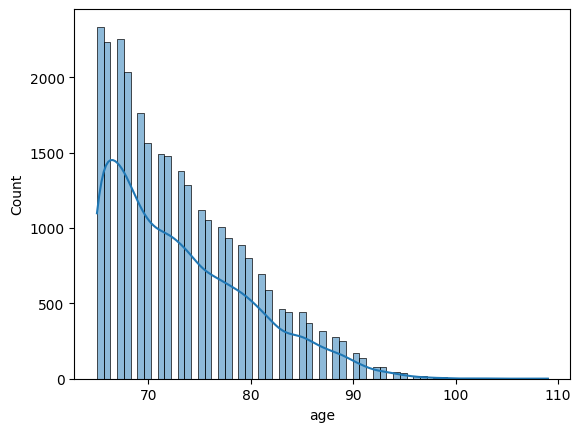

In [133]:
sns.histplot(df[df['GroupAge'] == 'e']['age'], kde=True)
#смотрим распределение возраста для возрастной категории e (там где все пропущенные значения)

In [134]:
df.drop('age', axis=1, inplace=True)
#принимаем решение удалить столбцы, так как пропусков очень много, а восстанавление в данном случае может ухудшить модель
#так же возраст удаляется по причине того, что есть столбец GroupAge которого достаточно для модели

In [135]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

<Axes: >

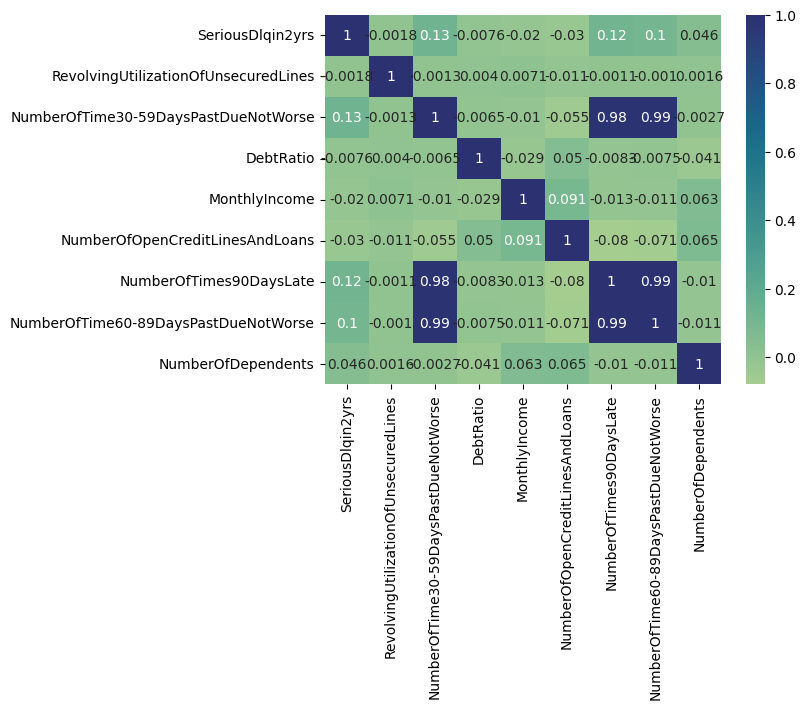

In [136]:
sns.heatmap(df.select_dtypes([int, float]).corr(), cmap='crest', annot=True)
#посмотрим матрицу корреляции чтобы убедиться что нет линейно зависимых связей с ЦЕЛЕВОЙ переменной SeriousDlqin2yrs

In [137]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

In [138]:
df.drop('MonthlyIncome', axis=1, inplace=True)
#по причине большого количества пропусков и небольшой корреляции с целевой переменной
#удаляем столбец MonthlyIncome

In [139]:
df.isnull().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      3924
RealEstateLoansOrLines                     0
GroupAge                                   0
dtype: int64

In [140]:
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)
#заполним пропуски NumberOfDependents

In [141]:
df.isnull().sum() #убеждаемся в отсутсвии нулевых значений

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
RealEstateLoansOrLines                  0
GroupAge                                0
dtype: int64

In [142]:
df = pd.get_dummies(df, dtype=int) #кодируем категориальные признаки

In [143]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines_A,RealEstateLoansOrLines_B,RealEstateLoansOrLines_C,RealEstateLoansOrLines_D,RealEstateLoansOrLines_E,GroupAge_b,GroupAge_c,GroupAge_d,GroupAge_e
0,0,0.221813,0,0.527888,7,0,0,2.0,1,0,0,0,0,0,1,0,0
1,0,0.602794,0,0.065868,2,0,0,0.0,1,0,0,0,0,1,0,0,0
2,1,0.025656,0,0.475841,7,0,0,2.0,1,0,0,0,0,0,1,0,0
3,0,0.075427,0,0.085512,6,0,0,0.0,1,0,0,0,0,1,0,0,0
4,0,0.046560,0,0.241622,9,0,0,0.0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.977899,0,517.000000,5,0,1,0.0,1,0,0,0,0,0,0,1,0
149996,0,0.025449,0,0.253855,7,0,0,2.0,1,0,0,0,0,0,0,1,0
149997,0,0.058001,0,0.013997,6,0,0,0.0,1,0,0,0,0,0,0,0,1
149998,0,0.071273,0,0.008638,3,0,0,1.0,1,0,0,0,0,0,1,0,0


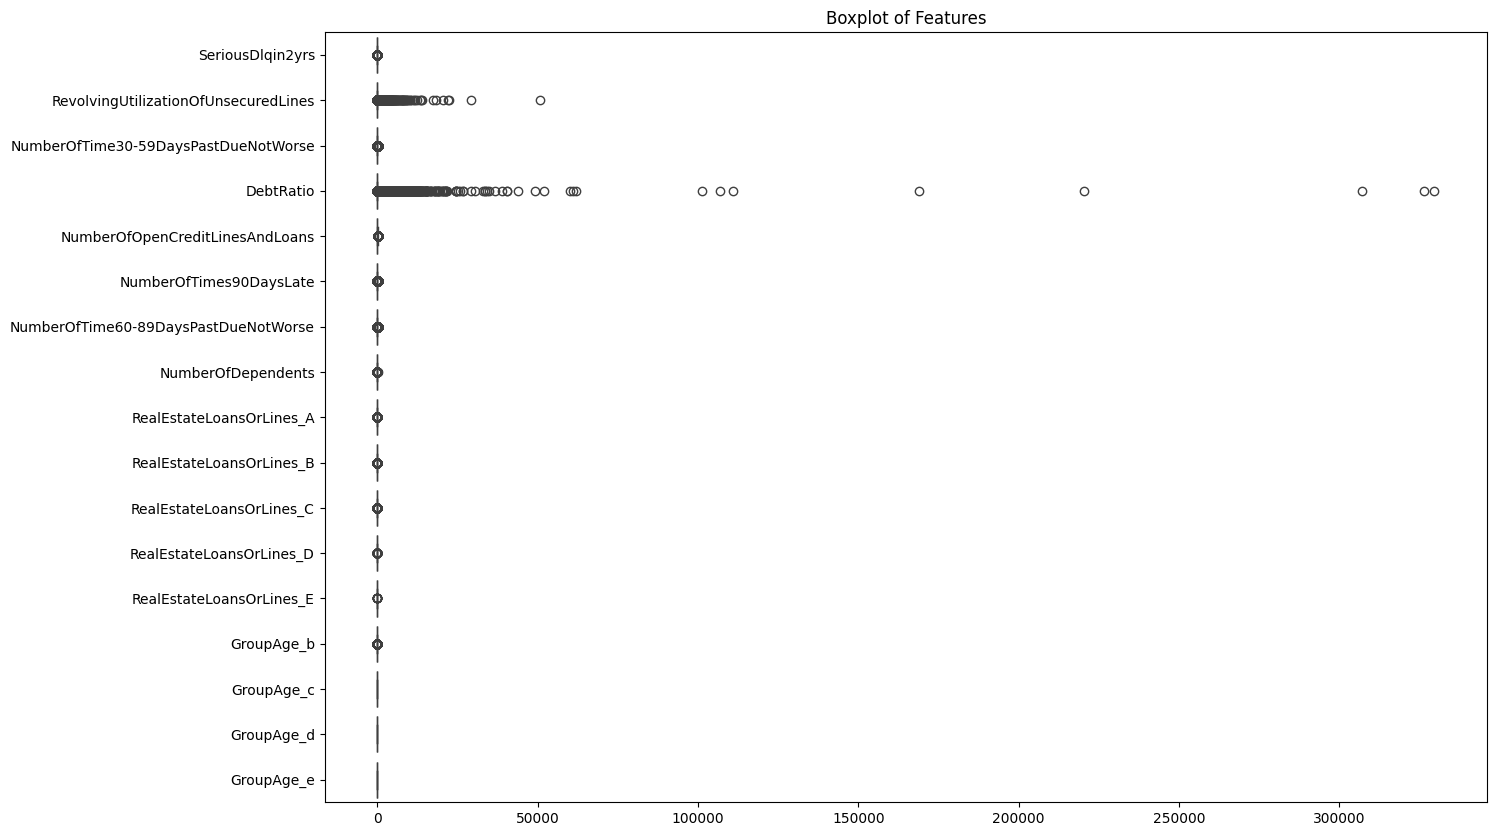

In [144]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, orient='h')
plt.title('Boxplot of Features')
plt.show()

In [145]:
df = df[df['DebtRatio'] < 15000]
df = df[df['RevolvingUtilizationOfUnsecuredLines']<10000]
# df = df[df['MonthlyIncome']<110000]
#удаляем самые явные выбросы

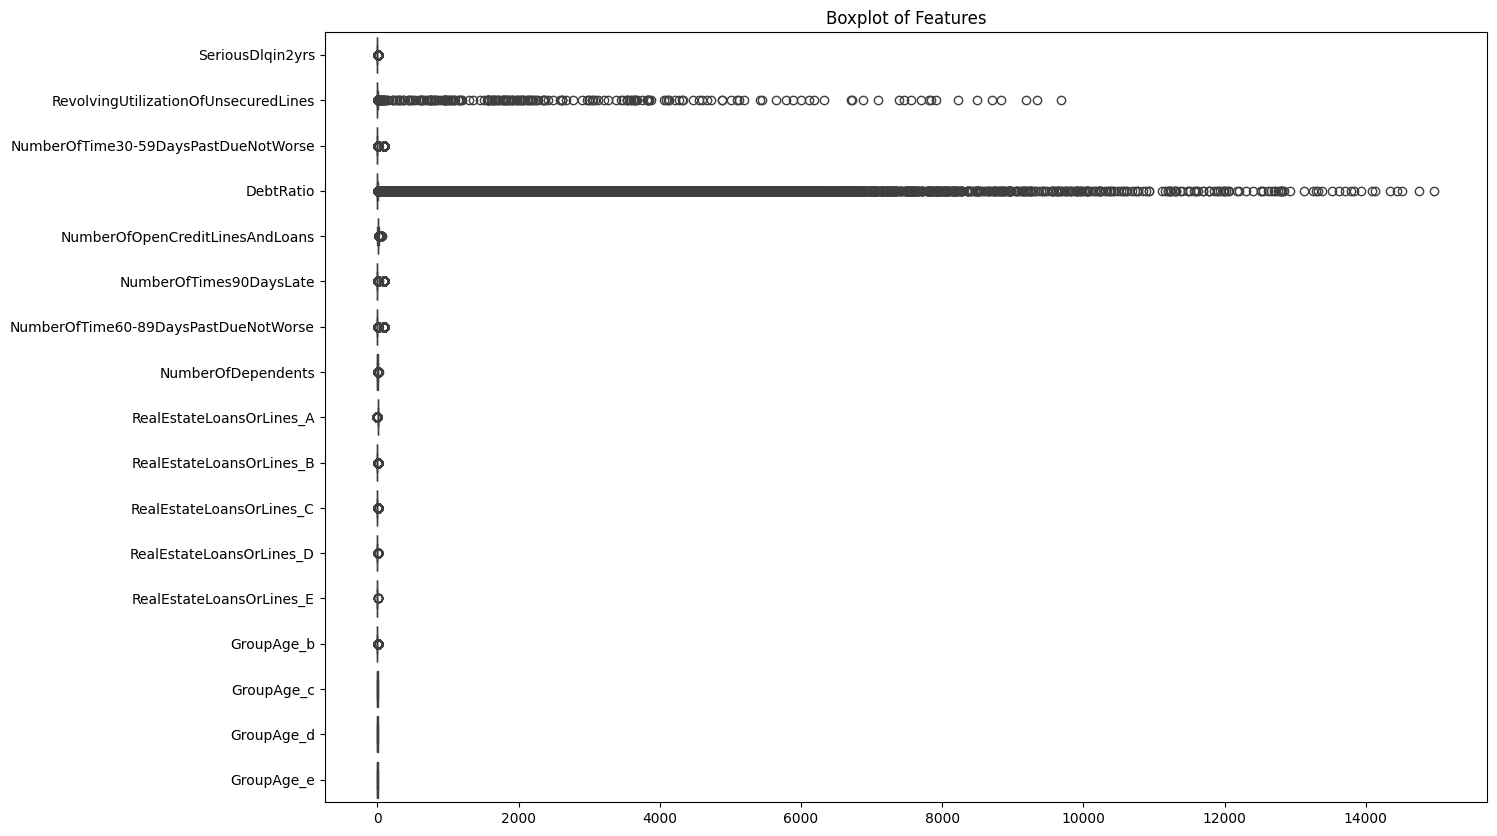

In [146]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, orient='h')
plt.title('Boxplot of Features')
plt.show()

In [147]:
X = df.drop('SeriousDlqin2yrs', axis=1) # матрица признаков
y = df['SeriousDlqin2yrs'] # целевая переменная

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # разбиваем на train и test

In [149]:
cb_clf = CatBoostClassifier(iterations=300,
                            random_state=42,
                            class_weights={0: 1, 1: 5}, #тк распределение сильно неравномерное добавляем штраф за ошибку классу 1
                            depth=8,
                            learning_rate=0.05,
                            eval_metric='F1',
                            verbose=2)
#лучшие параметры

In [150]:
cb_clf.fit(X_train, y_train)

0:	learn: 0.6142142	total: 39.5ms	remaining: 11.8s
2:	learn: 0.6332972	total: 111ms	remaining: 11s
4:	learn: 0.6315204	total: 186ms	remaining: 11s
6:	learn: 0.6348421	total: 262ms	remaining: 11s
8:	learn: 0.6343115	total: 347ms	remaining: 11.2s
10:	learn: 0.6212350	total: 414ms	remaining: 10.9s
12:	learn: 0.6271239	total: 486ms	remaining: 10.7s
14:	learn: 0.6267211	total: 561ms	remaining: 10.7s
16:	learn: 0.6260368	total: 634ms	remaining: 10.5s
18:	learn: 0.6243761	total: 711ms	remaining: 10.5s
20:	learn: 0.6279214	total: 795ms	remaining: 10.6s
22:	learn: 0.6298484	total: 889ms	remaining: 10.7s
24:	learn: 0.6282512	total: 965ms	remaining: 10.6s
26:	learn: 0.6284174	total: 1.03s	remaining: 10.4s
28:	learn: 0.6287982	total: 1.1s	remaining: 10.3s
30:	learn: 0.6275909	total: 1.18s	remaining: 10.2s
32:	learn: 0.6270086	total: 1.25s	remaining: 10.1s
34:	learn: 0.6263178	total: 1.33s	remaining: 10.1s
36:	learn: 0.6263856	total: 1.4s	remaining: 9.97s
38:	learn: 0.6264164	total: 1.47s	remaining

In [198]:
y_pred = cb_clf.predict(X_test)

In [199]:
print(classification_report(y_test, y_pred)) # замечаем, что точность для второго класса может быть выше

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     34975
           1       0.36      0.54      0.43      2504

    accuracy                           0.90     37479
   macro avg       0.66      0.73      0.69     37479
weighted avg       0.93      0.90      0.91     37479



In [208]:
y_pred_tuned = (cb_clf.predict_proba(X_test)[:, 1] >= 0.59).astype(int)
#поднимаем порог для увеличения точности

In [209]:
print(classification_report(y_test, y_pred_tuned)) #видим, что точность 0.4 для второго класса нас устраивает

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     34975
           1       0.40      0.46      0.43      2504

    accuracy                           0.92     37479
   macro avg       0.68      0.71      0.69     37479
weighted avg       0.92      0.92      0.92     37479



In [211]:
joblib.dump(cb_clf, 'best_catboost_model_credit_scoring.pkl')

['best_catboost_model_credit_scoring.pkl']

In [212]:
# best_model = joblib.load('best_catboost_model_credit_scoring.pkl')

In [213]:
# y_pred = best_model.predict(X_test)
# print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     34975
           1       0.36      0.54      0.43      2504

    accuracy                           0.90     37479
   macro avg       0.66      0.73      0.69     37479
weighted avg       0.93      0.90      0.91     37479

